In [1]:
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import xarray as xr
import glob
import om4labs.om4common as om4
import cftime

# parameters for setting circular cutoff for Southern Ocean plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [2]:
df = pd.read_csv('/work/Katherine.Turner/tempest-extremes/odiv-251/node_files/SH_SN.csv', delimiter='\t')
#df = pd.read_csv('/work/Katherine.Turner/tempest-extremes/ESM4/node_files/SH_SN.csv', delimiter='\t')

## Creating Dataset for number of storm centers per month for every month of the years included in the model runs

In [50]:
monthly_dates = xr.cftime_range(start="0001-01-01", end="0100-12-31", freq='MS', calendar='noleap')
monthly_centers = np.ones(len(monthly_dates))*np.nan
monthly_tracks = np.ones(len(monthly_dates))*np.nan

for i, date in enumerate(monthly_dates):
    storms_date = df[ (df['Month']==date.month) & (df['Year']==date.year)]
    monthly_centers[i] = len(storms_date)
    monthly_tracks[i] = len(storms_date['Event'].unique())

In [51]:
ds_out = xr.Dataset(
    data_vars=dict(
        center_counts = (["time"], monthly_centers),
        track_counts = (["time"], monthly_tracks),
    ),
    coords=dict(
        time=monthly_dates,
    ),
    attrs=dict(description="Monthly storm counts for ESM4")
)
ds_out

<xarray.Dataset>
Dimensions:        (time: 1200)
Coordinates:
  * time           (time) object 0001-01-01 00:00:00 ... 0100-12-01 00:00:00
Data variables:
    center_counts  (time) float64 655.0 672.0 761.0 830.0 ... 729.0 546.0 690.0
    track_counts   (time) float64 36.0 41.0 51.0 48.0 ... 52.0 46.0 38.0 37.0
Attributes:
    description:  Monthly storm counts for ESM4

In [52]:
ds_out.to_netcdf('/work/Katherine.Turner/smaller_projects/hifreq-variability/data/ESM4_monthly_storms.nc')

In [42]:
test = ds_out.center_counts.resample(time='QS-DEC').sum()
test[4:-1:4].sortby(test[4:-1:4]).time[:7], test[4:-1:4].sortby(test[4:-1:4]).time[-7:]

(<xarray.DataArray 'time' (time: 7)>
 array([cftime.DatetimeNoLeap(213, 12, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(212, 12, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(176, 12, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(225, 12, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(224, 12, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(205, 12, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(192, 12, 1, 0, 0, 0, 0, has_year_zero=True)],
       dtype=object)
 Coordinates:
   * time     (time) object 0213-12-01 00:00:00 ... 0192-12-01 00:00:00,
 <xarray.DataArray 'time' (time: 7)>
 array([cftime.DatetimeNoLeap(196, 12, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(228, 12, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(204, 12, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(239, 12, 1, 0, 0, 0, 0, has_year_zero

In [47]:
test2 = ds_out.center_counts[3:-3].coarsen(time=6).sum()
test2[1::2].sortby(test2[1::2]).time[:7], test2[1::2].sortby(test2[1::2]).time[-7:]

(<xarray.DataArray 'time' (time: 7)>
 array([cftime.DatetimeNoLeap(231, 12, 16, 8, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(212, 12, 16, 8, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(160, 12, 16, 8, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(236, 12, 16, 8, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(214, 12, 16, 8, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(176, 12, 16, 8, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(171, 12, 16, 8, 0, 0, 0, has_year_zero=True)],
       dtype=object)
 Coordinates:
   * time     (time) object 0231-12-16 08:00:00 ... 0171-12-16 08:00:00,
 <xarray.DataArray 'time' (time: 7)>
 array([cftime.DatetimeNoLeap(183, 12, 16, 8, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(181, 12, 16, 8, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(228, 12, 16, 8, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(229, 12, 16, 8, 0, 0, 0, ha

## Old method for testing out maximum and minimum storm seasons

In [3]:
df.loc[df['Month'].isin([1,2]), 'SeasonYear'] = df['Year'] - 1
df.loc[df['Month'].isin([3,4,5,6,7,8,9,10,11,12]), 'SeasonYear'] = df['Year']
df

,Event,Year,Month,Day,Time,Lon,Lat,SLP,Windspeed,SeasonYear
0,1,151,1,1,6,304.375,-54.5,97617.02,19.95753,150.0
1,1,151,1,1,12,308.125,-55.5,96888.99,20.16390,150.0
2,1,151,1,1,18,310.625,-56.5,96427.45,23.66224,150.0
3,1,151,1,2,0,313.125,-57.5,96506.70,23.68218,150.0
4,1,151,1,2,6,316.875,-57.5,96659.37,22.95042,150.0
...,...,...,...,...,...,...,...,...,...,...
866999,46809,245,12,31,0,5.625,-52.5,97325.49,17.00459,245.0
867000,46809,245,12,31,6,9.375,-53.5,97349.31,15.65946,245.0
867001,46809,245,12,31,12,15.625,-54.5,97593.02,16.05078,245.0
867002,46809,245,12,31,18,24.375,-55.5,97453.66,15.64064,245.0


In [4]:
df_winter = df[df['Month'].isin([6,7,8])]
df_summer = df[df['Month'].isin([1,2,12])]

In [5]:
year_counts_winter = df_winter['SeasonYear'].value_counts().sort_index()
year_counts_summer = df_summer['SeasonYear'].value_counts().sort_index()

year_counts_winter.index = year_counts_winter.index.astype(int)
year_counts_summer.index = year_counts_summer.index.astype(int)

In [11]:
year_counts_summer.index

Int64Index([151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
            164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
            177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
            190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
            203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,
            216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,
            229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241,
            242, 243, 244, 245, 246],
           dtype='int64')

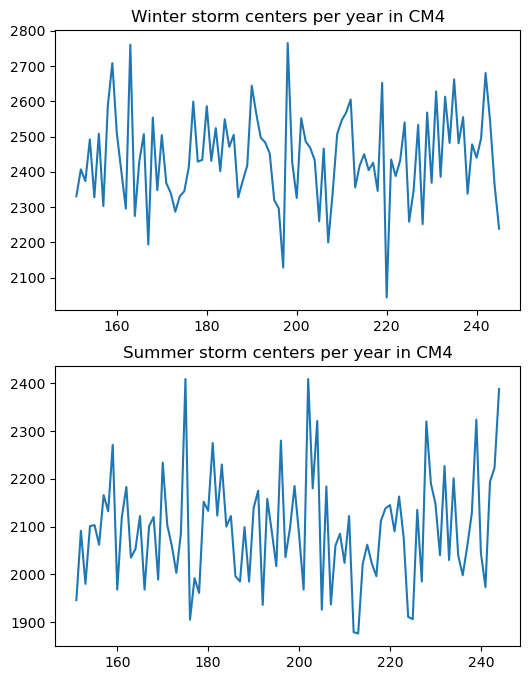

In [6]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(6,8))

year_counts_winter.plot(ax=axs[0])
axs[0].set_title('Winter storm centers per year in CM4')

year_counts_summer[1:-1].plot(ax=axs[1])
axs[1].set_title('Summer storm centers per year in CM4')

plt.savefig('/work/Katherine.Turner/smaller_projects/hifreq-variability/figures/CM4_storm_activity_seasonal.png', format='png', dpi=100)

In [7]:
np.corrcoef(year_counts_winter[1:], year_counts_summer[1:-1])

array([[1.        , 0.03314071],
       [0.03314071, 1.        ]])

In [59]:
df_summer

,Event,Year,Month,Day,Time,Lon,Lat,SLP,Windspeed,SeasonYear
0,1,151,1,1,6,304.375,-54.5,97617.02,19.95753,151.0
1,1,151,1,1,12,308.125,-55.5,96888.99,20.16390,151.0
2,1,151,1,1,18,310.625,-56.5,96427.45,23.66224,151.0
3,1,151,1,2,0,313.125,-57.5,96506.70,23.68218,151.0
4,1,151,1,2,6,316.875,-57.5,96659.37,22.95042,151.0
...,...,...,...,...,...,...,...,...,...,...
866999,46809,245,12,31,0,5.625,-52.5,97325.49,17.00459,246.0
867000,46809,245,12,31,6,9.375,-53.5,97349.31,15.65946,246.0
867001,46809,245,12,31,12,15.625,-54.5,97593.02,16.05078,246.0
867002,46809,245,12,31,18,24.375,-55.5,97453.66,15.64064,246.0


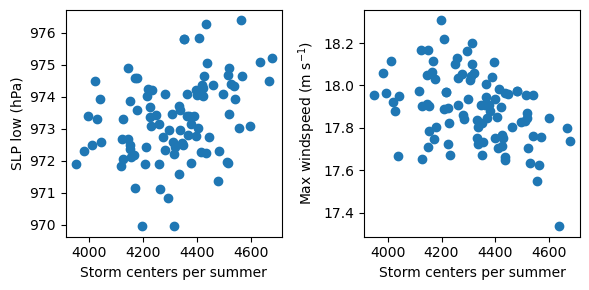

In [63]:
event_counts = np.zeros(len(year_counts_summer[1:-1]))
mean_slp = np.zeros(len(year_counts_summer[1:-1]))
mean_windmax = np.zeros(len(year_counts_summer[1:-1]))
for i, year in enumerate(year_counts_summer[1:-1].index):
    event_counts[i] = len(df_summer[df_summer['SeasonYear'] == year]['Event'].value_counts())
    mean_slp[i] = df_summer[df_summer['SeasonYear'] == year]['SLP'].mean()
    mean_windmax[i] = df_summer[df_summer['SeasonYear'] == year]['Windspeed'].mean()

fig, axs = plt.subplots(ncols=2, figsize=(6,3))
axs[0].scatter(year_counts_summer[1:-1], 1e-2*mean_slp)
axs[1].scatter(year_counts_summer[1:-1], mean_windmax)

axs[0].set_ylabel('SLP low (hPa)')
axs[0].set_xlabel('Storm centers per summer')

axs[1].set_ylabel('Max windspeed (m s$^{-1}$)')
axs[1].set_xlabel('Storm centers per summer')
#np.corrcoef(year_counts, mean_windmax)
plt.tight_layout()

In [25]:
print(np.corrcoef(year_counts_winter, mean_slp)[0,1])
print(np.corrcoef(year_counts_winter, mean_windmax)[0,1])

0.4031449183432485
-0.2526260327495952


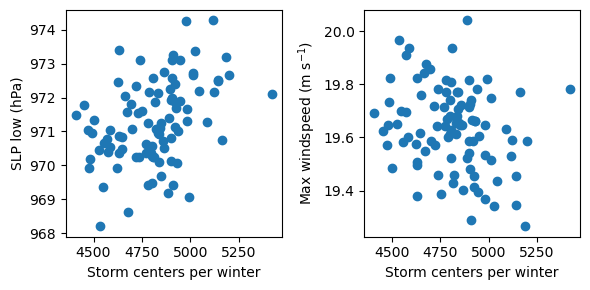

In [24]:
event_counts = np.zeros(len(year_counts_winter))
mean_slp = np.zeros(len(year_counts_winter))
mean_windmax = np.zeros(len(year_counts_winter))
for i, year in enumerate(year_counts_winter.index):
    event_counts[i] = len(df_winter[df_winter['Year'] == year]['Event'].value_counts())
    mean_slp[i] = df_winter[df_winter['Year'] == year]['SLP'].mean()
    mean_windmax[i] = df_winter[df_winter['Year'] == year]['Windspeed'].mean()

fig, axs = plt.subplots(ncols=2, figsize=(6,3))
axs[0].scatter(year_counts_winter, 1e-2*mean_slp)
axs[1].scatter(year_counts_winter, mean_windmax)

axs[0].set_ylabel('SLP low (hPa)')
axs[0].set_xlabel('Storm centers per winter')

axs[1].set_ylabel('Max windspeed (m s$^{-1}$)')
axs[1].set_xlabel('Storm centers per winter')
#np.corrcoef(year_counts, mean_windmax)
plt.tight_layout()

In [15]:
low_years = year_counts_summer[1:-1].sort_values()[:7].sort_index().index
high_years = year_counts_summer[1:-1].sort_values()[-7:].sort_index().index

high_years, low_years

(Int64Index([175, 196, 202, 204, 228, 239, 244], dtype='int64'),
 Int64Index([176, 192, 205, 212, 213, 224, 225], dtype='int64'))

In [16]:
low_years = year_counts_winter.sort_values()[:7].sort_index().index
high_years = year_counts_winter.sort_values()[-7:].sort_index().index

high_years, low_years

(Int64Index([159, 163, 190, 198, 219, 235, 242], dtype='int64'),
 Int64Index([167, 197, 207, 220, 225, 228, 245], dtype='int64'))

In [24]:
year_counts_winter.sort_values()[:7].mean()

2188.1428571428573

In [86]:
year_counts_summer[1:-1].sort_values()[:7].sum(), year_counts_summer[1:-1].sort_values()[-7:].sum()

(28024, 32266)

In [68]:
ds_mask = xr.open_mfdataset('/work/Katherine.Turner/tempest-extremes/odiv-251/comp_hfds/*masked*.nc', use_cftime=True)

In [70]:
da = ds_mask.resample(time='QS-DEC').sum()

In [87]:
winter_months = 6
summer_months_p1 = [10,11,12]
summer_months_p2 = [1,2,3]

idx_hi_mask = (ds_mask.time.dt.year.isin(high_years-1) & ds_mask.time.dt.month.isin(summer_months_p1)) | (ds_mask.time.dt.year.isin(high_years) & ds_mask.time.dt.month.isin(summer_months_p2)) 
idx_low_mask = (ds_mask.time.dt.year.isin(low_years-1) & ds_mask.time.dt.month.isin(summer_months_p1)) | (ds_mask.time.dt.year.isin(low_years) & ds_mask.time.dt.month.isin(summer_months_p2))

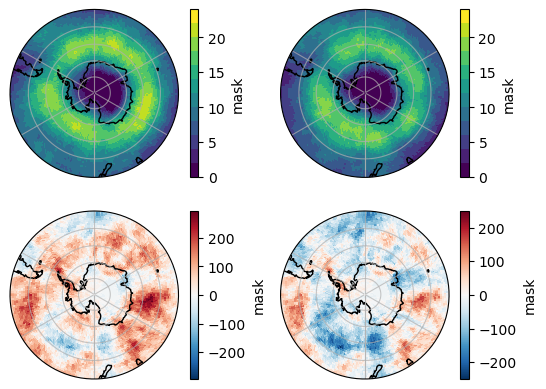

In [88]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs=axs.flatten()


(1/(6*7) * ds_mask.mask[idx_hi_mask,:,:].sum(dim='time')).plot(ax=axs[0], transform=ccrs.PlateCarree(), 
                                                               vmax=24, extend='neither',
                                                               cmap=plt.get_cmap('viridis', 12))
(1/(6*7) * ds_mask.mask[idx_low_mask,:,:].sum(dim='time')).plot(ax=axs[1], transform=ccrs.PlateCarree(), 
                                                               vmax=24, extend='neither',
                                                               cmap=plt.get_cmap('viridis', 12))

(ds_mask.mask[idx_hi_mask,:,:].sum(dim='time') - 
 ds_mask.mask[idx_low_mask,:,:].sum(dim='time')).plot(ax=axs[2], transform=ccrs.PlateCarree())

(28024/32266 * ds_mask.mask[idx_hi_mask,:,:].sum(dim='time') - 
 ds_mask.mask[idx_low_mask,:,:].sum(dim='time')).plot(ax=axs[3], transform=ccrs.PlateCarree())

for i in range(4):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()